<font size=8> Network Tests


In [1]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product

#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio



<font size=7> Manual Tuning


In [2]:
[board,profile_path,number_of_chips]=obtain_board()

In [3]:

neuron_config = neuron_configs_bio.config()

neuron_config['PC_Adaptation'] = True
neuron_config['duration'] = 15
neuron_config['input_type'] = 'Regular'
neuron_config['in_freq'] = 20
neuron_config['nvn'] = 15
neuron_config['pcn'] = 100
neuron_config['pvn'] = 20
neuron_config['sstn'] = 15

@timeout_decorator.timeout(50)  # Set a 5-second timeout
def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
        
    )


In [4]:

#create grid search parameters
param_grid = {
    'SST_W0': product([1,2,3],[10,50,100,200]),
    'SST_AMPA_GAIN': product([1,2,3], [10,100,150,200]),
    'SST_AMPA_TAU': product([0],[10,20,40,60]), #80-120
    'SST_LEAK': product([1], [40,20]),# 10-30
    'Input_SST': [.05, .1,.2],
    'PC_SST': [.05, .1,.2]
}

# STD 
# Flatten the product for the parameters
expanded_param_grid = {
    key: list(value) for key, value in param_grid.items()
}

param_values = list(expanded_param_grid.values())
total_combinations = len(list(product(*param_values))) # Total number of parameter combinations


# Load previous unique results to skip simulations that have already been run
try:
    with open('results_grid_1.pkl', 'rb') as f:
        results = pickle.load(f)
    unique_params_set = set(tuple(entry[0].items()) for entry in results)
except FileNotFoundError:
    unique_params_set = set()

start_time = time.time()  # Record the start time

# Iterate through the parameter grid 
for i, params in enumerate(product(*param_values), start=0):

    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    
    if elapsed_time > 21600:  # 21600 seconds == 6 hours
        print("6 hours have passed. Ending the simulation.")
        break  # Break out of the loop

    print(f"Running simulation {i+1}/{total_combinations}...")

    # Create a dictionary of the current parameter values, flattening product objects
    current_params = {
        key: (item[0], item[1]) if isinstance(item, tuple) else item
        for key, item in zip(expanded_param_grid.keys(), params)
    }

    # Skip this simulation if its parameters have already been run
    if tuple(current_params.items()) in unique_params_set:
        print(f"Skipping simulation {i+1}/{total_combinations} as it has already been run.")
        continue

    
    # Update the values in neuron_config with the current parameter values
    neuron_config.update(current_params)
    print('current parameters')
    try:
        [output_events, test_config] = run_simulation(neuron_config)
        fot_output= frequency_over_time(test_config, output_events)
        time_stamp=test_config['date_label']+'-'+test_config['time_label']

        [time_axis, ff_windows_pc, ff_windows_pv, ff_windows_sst] = fot_output
        fvt_fig = frequency_vs_time_plot(frequency_over_time(test_config, output_events), test_config, save=True, annotate=True,neuron_config=neuron_config)
        slope = calculate_slope(time_axis, ff_windows_sst)
        results.append((current_params, slope,time_stamp))  # Storing the current_params instead of neuron_config
        # Save Progress
        with open('results_grid_1.pkl', 'wb') as f:
            pickle.dump(results, f)
    except timeout_decorator.TimeoutError:
        results.append((current_params, 'N/A','N/A'))  # Storing the current_params instead of neuron_config
        # Save progress
        with open('results_grid_1.pkl', 'wb') as f:
            pickle.dump(results, f)
        print("Simulation timed out, trying again with new parameters...")

print("Simulation completed")



Running simulation 1/10368...
current parameters
Setting Latches
Setting up network
Adding connections

Setting monitors
20 100 15

All configurations done!

Input events created
initilize run dynapse
initilize run dynapse

getting fpga time


setting virtual neurons

Simulation done
Running simulation 2/10368...
current parameters
Setting Latches
Setting up network
Adding connections

Setting monitors
20 100 15

All configurations done!

Input events created
initilize run dynapse
initilize run dynapse

getting fpga time


setting virtual neurons

Simulation done
Running simulation 3/10368...
current parameters
Setting Latches
Setting up network
Adding connections

Setting monitors
20 100 15

All configurations done!

Input events created
initilize run dynapse
initilize run dynapse

getting fpga time


setting virtual neurons

Simulation done
Running simulation 4/10368...
current parameters
Setting Latches
Setting up network
Adding connections

Setting monitors
20 100 15

All configura

In [5]:
print(results[-1])

({'SST_W0': (1, 10), 'SST_AMPA_GAIN': (2, 200), 'SST_AMPA_TAU': (0, 40), 'SST_LEAK': (1, 20), 'Input_SST': 0.2, 'PC_SST': 0.2}, 0.0006881621768864222, '2023-09-07-23-44')


In [6]:
import pandas as pd
import pickle

# Load previous results if available
try:
    with open('results_grid_1.pkl', 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = []
print(results)

# Convert to DataFrame
df = pd.DataFrame([dict(entry[0], **{'Result': entry[1], 'Timestamp': entry[2]}) for entry in results])

# Save to Excel
df.to_excel("results_1_chart_with_timestamp.xlsx", index=False)


[({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.05, 'PC_SST': 0.05}, 0.0, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.05, 'PC_SST': 0.1}, 0.003249654724185557, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.05, 'PC_SST': 0.2}, 0.010408452925406094, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.1, 'PC_SST': 0.05}, 0.0, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.1, 'PC_SST': 0.1}, 0.0, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.1, 'PC_SST': 0.2}, 0.005820705079497074, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_

/tmp/ipykernel_203099/1213821021.py:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df[col], y=df['Result'], ax=ax, palette='viridis', alpha=0.7)
/tmp/ipykernel_203099/1213821021.py:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df[col], y=df['Result'], ax=ax, palette='viridis', alpha=0.7)


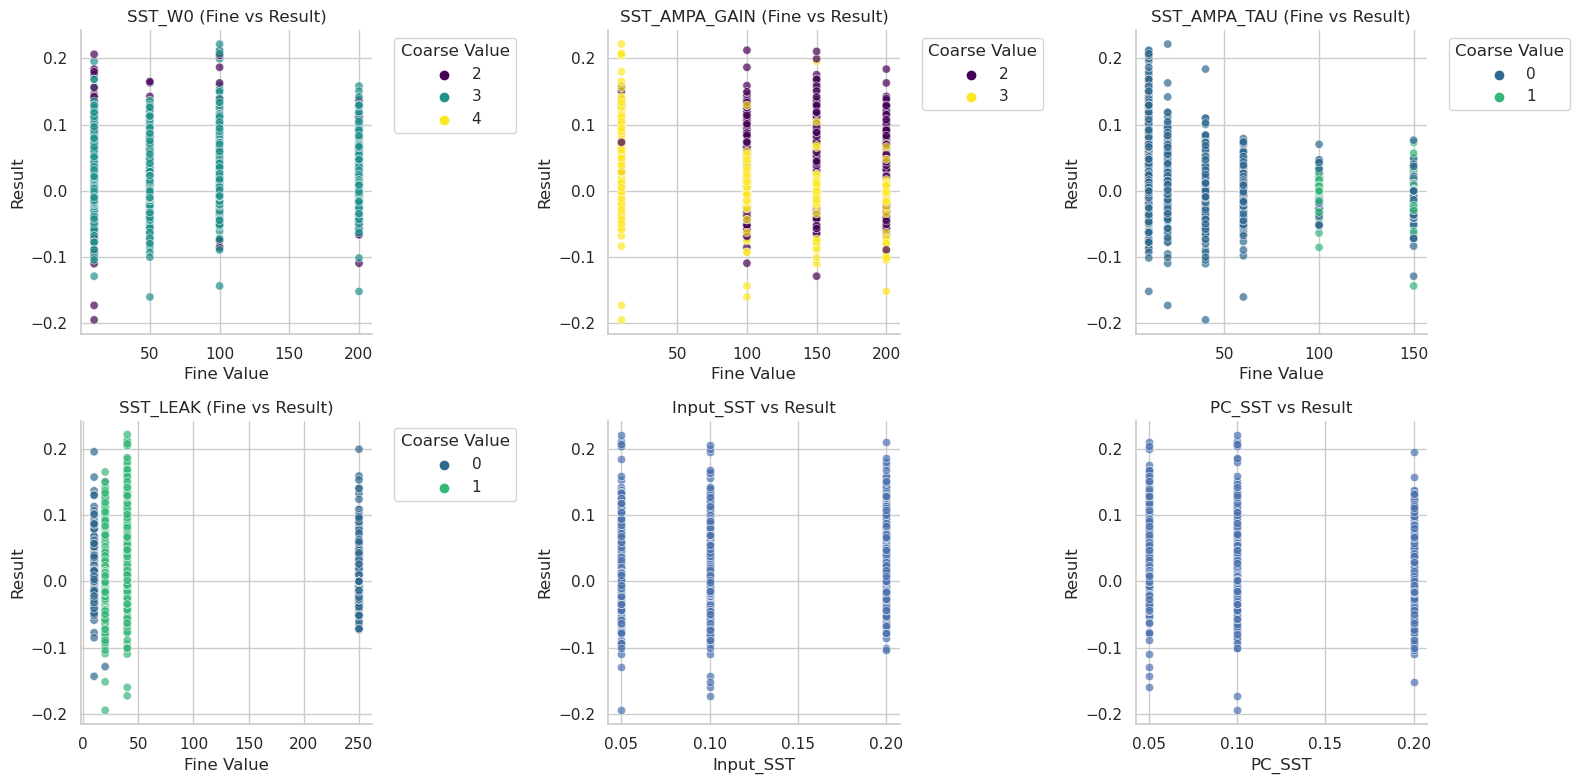

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_subplots_final_styled(df):
    sns.set(style="whitegrid")

    df = df[df['Result'] != 'N/A']

    
    # Manually identify the columns containing tuples (assumed to be coarse and fine values)
    tuple_columns = ['SST_W0', 'SST_AMPA_GAIN', 'SST_AMPA_TAU', 'SST_LEAK']
    
    # Identify the columns containing single values
    single_value_columns = [col for col in df.columns if df[col].dtype != 'object' and col not in ['Result', 'Timestamp']]
    
    # Total number of subplots
    total_subplots = len(tuple_columns) + len(single_value_columns)
    
    # Layout for subplots
    rows = int(total_subplots ** 0.5)
    cols = int(total_subplots / rows) + (total_subplots % rows > 0)
    
    # Initialize subplots
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten()
    
    # Plotting for tuple-format parameters
    for i, col in enumerate(tuple_columns):
        ax = axes[i]
        # Convert string representation of tuples to actual tuples, but only for string types
        tuple_values = df[col].apply(lambda x: eval(x) if isinstance(x, str) else x)
        # Extract coarse and fine values from the tuples
        coarse_values, fine_values = zip(*tuple_values)
        # Plot
        sns.scatterplot(x=fine_values, y=df['Result'], hue=coarse_values, ax=ax, palette='viridis', alpha=0.7)
        ax.set_title(f"{col} (Fine vs Result)")
        ax.set_xlabel("Fine Value")
        ax.set_ylabel("Result")
        ax.legend(title="Coarse Value", bbox_to_anchor=(1.05, 1), loc='upper left')
        sns.despine(ax=ax, top=True, right=True)
    
    # Plotting for single-value parameters
    for i, col in enumerate(single_value_columns):
        ax = axes[len(tuple_columns) + i]
        sns.scatterplot(x=df[col], y=df['Result'], ax=ax, palette='viridis', alpha=0.7)
        ax.set_title(f"{col} vs Result")
        ax.set_xlabel(col)
        ax.set_ylabel("Result")
        sns.despine(ax=ax, top=True, right=True)
    
    # Remove extra subplots
    for i in range(total_subplots, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    plt.show()

# To use the function, simply pass your DataFrame to it like so:
# plot_subplots_final_styled(your_dataframe)


# To use the function, simply pass your DataFrame to it like so:
# plot_subplots_final_styled(your_dataframe)
plot_subplots_final_styled(df)